In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/detecting-fraud/test_data.csv
/kaggle/input/detecting-fraud/train_data.csv


In [20]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import calendar
import plotly
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [21]:
df = pd.read_csv('../input/detecting-fraud/train_data.csv')
test = pd.read_csv('../input/detecting-fraud/test_data.csv')

### Converting into date time

In [22]:
df['date_time'] = pd.to_datetime(df['transaction_initiation'])
df['date'] = df['date_time'].dt.date
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['week_day'] = df['date_time'].dt.weekday
df['hour'] = df['date_time'].dt.hour

In [23]:
df.head(2)

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,date_time,date,year,month,week_day,hour
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0,2016-11-15 19:16:12+00:00,2016-11-15,2016,11,1,19
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0,2017-01-11 09:25:33+00:00,2017-01-11,2017,1,2,9


In [24]:
df.describe(include='all')

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,date_time,date,year,month,week_day,hour
count,7.652900e+04,7.652900e+04,76529,76529.000000,76529,76529,76529,76529.000000,76529,76529.000000,76529.000000,76529,76529,76529.000000,76529.000000,76529.000000,76529.000000
unique,NaN,NaN,6,NaN,9,1,4,NaN,75811,NaN,NaN,75811,91,NaN,NaN,NaN,NaN
top,NaN,NaN,sbi_atm_cum_debit_card,NaN,cat_1,IND_INR,other_pcs,NaN,2016-12-24 16:30:13+00:00,NaN,NaN,2016-12-24 16:30:13+00:00,2017-02-01,NaN,NaN,NaN,NaN
freq,NaN,NaN,30538,NaN,36306,76529,45560,NaN,12,NaN,NaN,12,2386,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-11-15 02:18:49+00:00,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-02-13 10:01:28+00:00,NaN,NaN,NaN,NaN,NaN
mean,6.940200e+14,1.247483e+07,NaN,58497.189105,NaN,NaN,NaN,132.724348,NaN,2.255707,0.002012,NaN,NaN,2016.496100,6.576958,2.976911,12.452260
std,7.867885e+14,1.205878e+07,NaN,36740.216787,NaN,NaN,NaN,2350.110900,NaN,0.732174,0.044814,NaN,NaN,0.499988,5.223658,1.929435,4.850698
min,8.000000e+00,1.000000e+00,NaN,7889.000000,NaN,NaN,NaN,-20000.000000,NaN,0.000000,0.000000,NaN,NaN,2016.000000,1.000000,0.000000,0.000000
25%,4.387866e+13,3.515625e+06,NaN,23667.000000,NaN,NaN,NaN,-1.000000,NaN,2.000000,0.000000,NaN,NaN,2016.000000,1.000000,2.000000,8.000000


In [32]:
df.head(2)

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,date_time,date,year,month,week_day,hour
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0,2016-11-15 19:16:12+00:00,2016-11-15,2016,11,1,19
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0,2017-01-11 09:25:33+00:00,2017-01-11,2017,1,2,9


In [26]:
df['payment_method'] = df['payment_method'].astype('category')
df['device_type'] = df['device_type'].astype('category')

In [27]:
print(df.user_id.nunique())
print(df.transaction_number.nunique())

3594
76529


### There are 76529 transactions and 3594 unique users.

In [33]:
df.drop(['country', 'transaction_number', 'transaction_initiation', 'date_time'],axis=1, inplace=True)

In [35]:
df.partner_id.nunique()

23

In [ ]:
test.partner_category.value_counts()

In [37]:
def barplot(col,df):
    barplot1=sns.countplot(x=col, data=df)
    total=len(df[col])
    for p in barplot1.patches:
        percentage='{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        barplot1.text(p.get_x() + p.get_width()/2, height, percentage, ha='center')

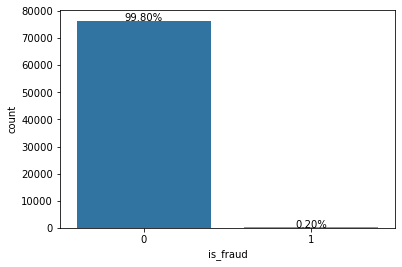

In [38]:
barplot('is_fraud',df)

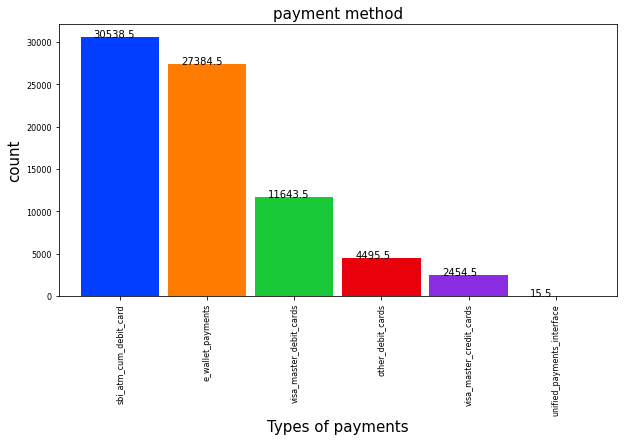

In [39]:
plt.subplots(figsize=(10,5))
ax = df['payment_method'].value_counts().plot.bar(width=0.9, color=sns.color_palette('bright',20), fontsize=8)
for p in ax.patches:
    ax.annotate(format(p.get_height()+0.5), (p.get_x()+0.15,p.get_height()+1))
plt.title('payment method', fontsize=15)
plt.xlabel('Types of payments', fontsize=15)
plt.ylabel('count',fontsize=15)
plt.show()

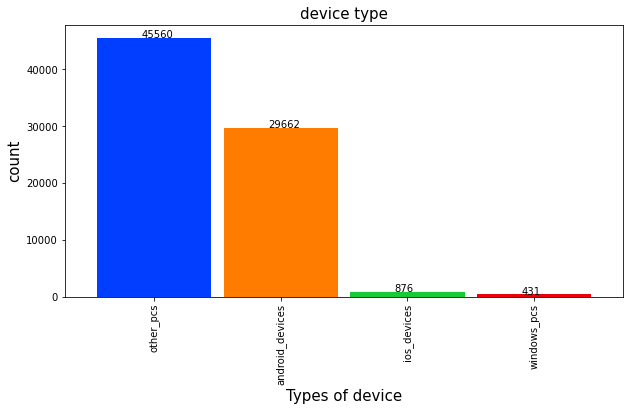

In [40]:
plt.subplots(figsize=(10,5))
ax = df['device_type'].value_counts().plot.bar(width=0.9, color=sns.color_palette('bright',10))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.35,p.get_height()+1))
plt.title('device type', fontsize=15)
plt.xlabel('Types of device', fontsize=15)
plt.ylabel('count',fontsize=15)
plt.show()    

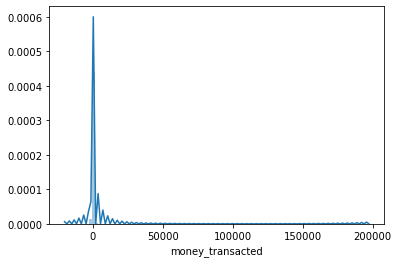

In [41]:
sns.distplot(df['money_transacted'], bins=100)

In [42]:
col = ['user_id','payment_method','partner_id','partner_category','device_type','partner_pricing_category','is_fraud']
for cat in col:
    df[cat] = df[cat].astype('category')

In [43]:
df['is_fraud'] = df['is_fraud'].replace(to_replace=[0,1], value=['No','Yes'])

In [44]:
temp = df.groupby(['payment_method','is_fraud']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['payment','is_fraud','Count']

trace1 = go.Bar(x=temp.payment[temp.is_fraud=='No'],
               y=temp.Count[temp.is_fraud=='No']/temp.Count.sum(), name='Not Fraud')
trace2 = go.Bar(x=temp.payment[temp.is_fraud=='Yes'],
               y=temp.Count[temp.is_fraud=='Yes']/temp.Count.sum(), name='Fraud')
data = [trace1,trace2]
layout = go.Layout(width=800, height=500, title='Payment type', barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [45]:
temp = df.groupby(['device_type','is_fraud']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['device_type','is_fraud','Count']

trace1 = go.Bar(x=temp.device_type[temp.is_fraud=='No'],
               y=temp.Count[temp.is_fraud=='No']/temp.Count.sum(), name='Not Fraud')
trace2 = go.Bar(x=temp.device_type[temp.is_fraud=='Yes'],
               y=temp.Count[temp.is_fraud=='Yes']/temp.Count.sum(), name='Fraud')

data = [trace1,trace2]
layout = go.Layout(width=800, height=500, title='Payment type', barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.show()

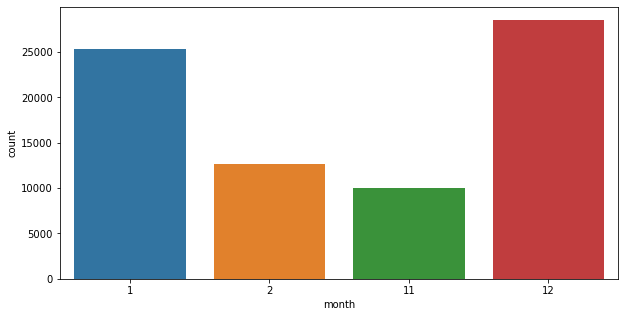

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df['month'], ax=ax)

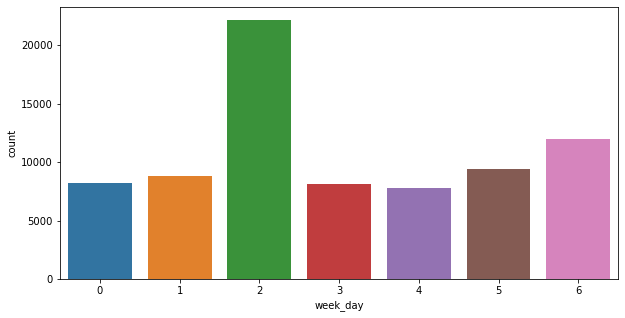

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(df['week_day'], ax=ax)

In [48]:
bins = 0, 4, 8, 12, 16, 20, 24
group_names = ['LateNight','EarlyMrng','Morning','Noon','Evening','Night']
df['TimeOfDay'] = pd.cut(df['hour'],bins,labels=group_names)

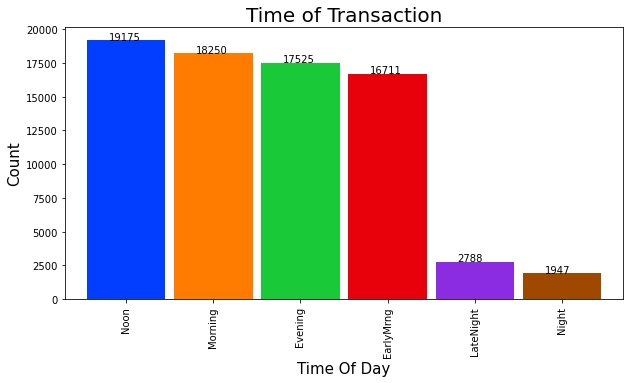

In [49]:
plt.subplots(figsize=(10,5))
ax=df['TimeOfDay'].value_counts().plot.bar(width=0.9, color=sns.color_palette('bright',15))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.25,p.get_height()+1))

plt.title("Time of Transaction", fontsize=20)
plt.xlabel("Time Of Day", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()    

<Figure size 1440x360 with 0 Axes>

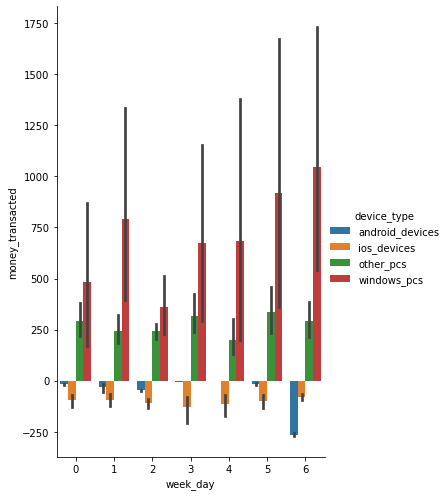

In [50]:
plt.figure(figsize=(20,5))
sns.catplot(x='week_day',y='money_transacted',hue='device_type',data=df,kind='bar',height=7,aspect=.7)
plt.show()

In [52]:
temp = df.groupby(['TimeOfDay','is_fraud']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['TimeOfDay','is_fraud','Count']

trace1 = go.Bar(x=temp.TimeOfDay[temp.is_fraud=='No'],
               y=temp.Count[temp.is_fraud=='No']/temp.Count.sum(), name='Not Fraud')
trace2 = go.Bar(x=temp.TimeOfDay[temp.is_fraud=='Yes'],
               y=temp.Count[temp.is_fraud=='Yes']/temp.Count.sum(), name='Fraud')

data = [trace1,trace2]
layout = go.Layout(width=800, height=500, title='Payment time', barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [53]:
temp = df.groupby(['partner_category','is_fraud']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['partner_category','is_fraud','Count']

trace1 = go.Bar(x=temp.partner_category[temp.is_fraud=='No'],
               y=temp.Count[temp.is_fraud=='No']/temp.Count.sum(), name='Not Fraud')
trace2 = go.Bar(x=temp.partner_category[temp.is_fraud=='Yes'],
               y=temp.Count[temp.is_fraud=='Yes']/temp.Count.sum(), name='Fraud')

data = [trace1,trace2]
layout = go.Layout(width=800, height=500, title='Week Day', barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [54]:
temp = df.groupby(['week_day','is_fraud']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['week_day','is_fraud','Count']

trace1 = go.Bar(x=temp.week_day[temp.is_fraud=='No'],
               y=temp.Count[temp.is_fraud=='No']/temp.Count.sum(), name='Not Fraud')
trace2 = go.Bar(x=temp.week_day[temp.is_fraud=='Yes'],
               y=temp.Count[temp.is_fraud=='Yes']/temp.Count.sum(), name='Fraud')

data = [trace1,trace2]
layout = go.Layout(width=800, height=500, title='Week Day', barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [55]:
trace1 = go.Box(y = df.money_transacted[df.is_fraud=='Yes'], name='Fraud')
trace2 = go.Box(y=df.money_transacted[df.is_fraud=='No'], name='Not Fraud')

data = [trace1,trace2]
layout = go.Layout(width=600,height=400,title='Fraud or not')
fig = go.Figure(data=data, layout=layout)
fig.show()

In [56]:
df['user_id'].loc[(df['money_transacted']>9000) & (df['is_fraud']== 'Yes')].count()

134

In [57]:
134/154 * 100

87.01298701298701

### 87% of transactions has happened when money transaction is greater than 9000

In [58]:
df['is_fraud']=df['is_fraud'].astype('category')

In [59]:
def get_prob(col, target, df, forGraph=True):
    crosstab = pd.crosstab(index=df[col],columns=df[target])
    crosstab.columns = pd.Index(list(crosstab.columns))
    crosstab = crosstab.reset_index()
    crosstab['total'] = crosstab['Yes'] + crosstab['No']
    crosstab['prob'] = crosstab['Yes']/crosstab['total']
    
    print(crosstab.head())
    if forGraph:
        return crosstab[[col,'prob']]
    else:
        return crosstab[[col,'total','prob']]

In [60]:
data = get_prob('money_transacted','is_fraud',df)

   money_transacted  No  Yes  total  prob
0          -20000.0   1    0      1   0.0
1          -18000.0   0    1      1   1.0
2          -10000.0   0    3      3   1.0
3           -4000.0   7    0      7   0.0
4           -3200.0   1    0      1   0.0


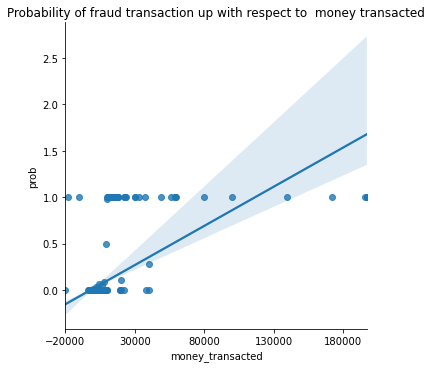

In [61]:
sns.lmplot(data=data,x='money_transacted',y='prob',fit_reg=True)
plt.xticks(np.arange(np.min(df['money_transacted']), np.max(df['money_transacted']), 50000))
plt.title('Probability of fraud transaction up with respect to  money transacted')
plt.show()

### It is clear that as the probablity of fraud more as transaction increases

In [69]:
df.loc[(df.money_transacted) >50000]

31

In [70]:
df['user_id'].loc[(df.money_transacted)>5000].count()

272

In [71]:
df['user_id'].loc[(df.money_transacted)<0].count()

30538

In [72]:
df['partner_id'].loc[(df['partner_id']==23667) & (df['is_fraud']== 'Yes')].count()

9

In [73]:
df['user_id'].loc[(df['partner_id']==118335) & (df['is_fraud']== 'Yes')].count()

124

### Partner ID 118335 has 80% of fraud transactions 

In [74]:
df['partner_id'].loc[(df['partner_id']==23667) & (df['is_fraud']== 'Yes')].count()

9

In [78]:
df['partner_id'].loc[(df['partner_id']==78890) & (df['is_fraud']== 'Yes')].count()

6

### Out of 23 partner id's (78890, 23667, 118335, 23667) combined has 96% of fraud transactions.

In [84]:
df.drop(['partner_id','year'],axis=1,inplace=True)

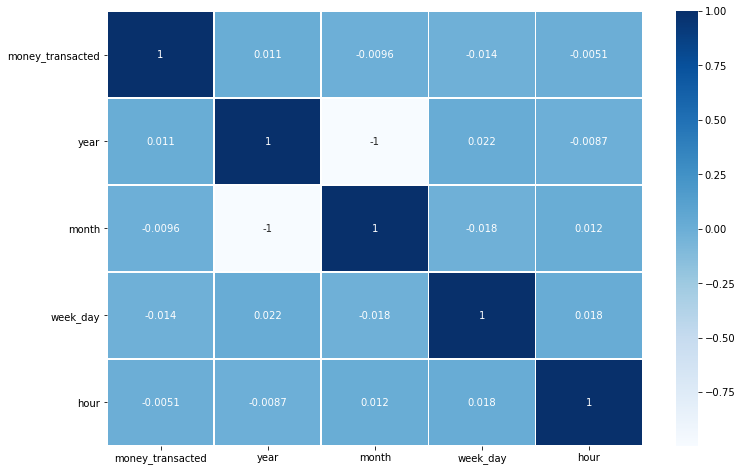

In [82]:
corr = df.corr()
plt.figure(figsize=(12,8))
ax = sns.heatmap(corr,annot=True,cmap='Blues',linewidths=0.5)

In [85]:
df['is_fraud'].value_counts()

No     76375
Yes      154
Name: is_fraud, dtype: int64

In [86]:
df.drop('TimeOfDay',axis=1,inplace=True)

In [87]:
df['is_fraud'] = df['is_fraud'].replace(to_replace=['No','Yes'], value=[0,1])


In [88]:
df.loc[(df.partner_category=='cat_9'),]

,payment_method,partner_category,device_type,money_transacted,partner_pricing_category,is_fraud,month,week_day,hour
20333,visa_master_credit_cards,cat_9,other_pcs,10.0,1,0,12,1,8
39225,visa_master_credit_cards,cat_9,other_pcs,10.0,1,0,12,1,8


In [90]:
df.drop([20333,39225],axis=0,inplace=True)

In [91]:
y = df['is_fraud']
X = df.drop('is_fraud',axis=1)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=190)

In [92]:
num_attr = X_train.select_dtypes(['int64','float64']).columns
cat_attr = X_train.select_dtypes('category').columns

In [93]:
standard = StandardScaler()
standard.fit(X_train[num_attr])
X_train_std = standard.transform(X_train[num_attr])
X_val_std = standard.transform(X_val[num_attr])

X_train_num = pd.DataFrame(X_train_std, columns=num_attr)
X_val_num = pd.DataFrame(X_val_std, columns=num_attr)

In [94]:
ohe = OneHotEncoder()

In [95]:
ohe.fit(X_train[cat_attr])

columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)

X_train_cat = ohe.transform(X_train[cat_attr])
X_val_cat = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_val_cat = pd.DataFrame(X_val_cat.todense(), columns=columns_ohe)               


['payment_method_e_wallet_payments', 'payment_method_other_debit_cards', 'payment_method_sbi_atm_cum_debit_card', 'payment_method_unified_payments_interface', 'payment_method_visa_master_credit_cards', 'payment_method_visa_master_debit_cards', 'partner_category_cat_1', 'partner_category_cat_2', 'partner_category_cat_3', 'partner_category_cat_4', 'partner_category_cat_5', 'partner_category_cat_6', 'partner_category_cat_7', 'partner_category_cat_8', 'device_type_android_devices', 'device_type_ios_devices', 'device_type_other_pcs', 'device_type_windows_pcs', 'partner_pricing_category_0', 'partner_pricing_category_1', 'partner_pricing_category_2', 'partner_pricing_category_4']


In [96]:
X_train = pd.concat([X_train_num, X_train_cat],axis=1)
X_val = pd.concat([X_val_num, X_val_cat],axis=1)
print(X_train.shape)
print(X_val.shape)

(53568, 26)
(22959, 26)


In [97]:
scores = pd.DataFrame(columns=['Model','Train_accuracy','Train_recall','Train_precision','Train_F1score',
                              'Test_accuracy', 'Test_recall','Test_precision','Test_F1score'])
def getmetrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    
    train_accuracy=accuracy_score(train_actual,train_predicted)
    train_recall=recall_score(train_actual,train_predicted)
    train_precision=precision_score(train_actual,train_predicted)
    train_f1score=f1_score(train_actual,train_predicted)
    test_accuracy=accuracy_score(test_actual,test_predicted)
    test_recall=recall_score(test_actual,test_predicted)
    test_precision=precision_score(test_actual,test_predicted)
    test_f1score=f1_score(test_actual,test_predicted)
    dataframe=dataframe.append(pd.Series([model_description,train_accuracy,train_recall,train_precision,
                                          train_f1score,test_accuracy,test_recall,test_precision,test_f1score],
                                         index=scores.columns),ignore_index=True)
    return(dataframe)

In [98]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
logistic_train_pred = logistic.predict(X_train)
logistic_val_pred = logistic.predict(X_val)

In [99]:
f1_log = precision_score(y_val,logistic_val_pred)
f1_log

0.6086956521739131

In [100]:
print(classification_report(y_val, logistic_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22929
           1       0.61      0.47      0.53        30

    accuracy                           1.00     22959
   macro avg       0.80      0.73      0.76     22959
weighted avg       1.00      1.00      1.00     22959



In [101]:
scores = getmetrics(y_train,logistic_train_pred,y_val,logistic_val_pred,"Logistic regression",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302


In [102]:
scores = getmetrics(y_train,logistic_train_pred,y_val,logistic_val_pred,"Log_Reg_not_balanced",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
1,Log_Reg_not_balanced,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302


In [103]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_train_pred = logistic.predict(X_train)
knn_val_pred = logistic.predict(X_val)
knn_f1 = f1_score(logistic_val_pred,y_val)
knn_f1

0.5283018867924527

In [104]:
print(classification_report(y_val, knn_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22929
           1       0.61      0.47      0.53        30

    accuracy                           1.00     22959
   macro avg       0.80      0.73      0.76     22959
weighted avg       1.00      1.00      1.00     22959



In [105]:
scores = getmetrics(y_train,knn_train_pred,y_val,knn_val_pred,"KNN",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
1,Log_Reg_not_balanced,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
2,KNN,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302


In [106]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train, y_train)
dt_train_pred = dt.predict(X_train)
dt_val_pred = dt.predict(X_val)
dt_f1 = f1_score(dt_val_pred,y_val)
dt_f1

0.8135593220338982

In [107]:
print(classification_report(y_val, dt_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22929
           1       0.83      0.80      0.81        30

    accuracy                           1.00     22959
   macro avg       0.91      0.90      0.91     22959
weighted avg       1.00      1.00      1.00     22959



In [108]:
scores = getmetrics(y_train,dt_train_pred,y_val,dt_val_pred,"Decision Tree",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
1,Log_Reg_not_balanced,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
2,KNN,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
3,Decision Tree,0.999907,0.959677,1.000000,0.979424,0.999521,0.800000,0.827586,0.813559


In [109]:
dt1 = DecisionTreeClassifier(class_weight='balanced')
dt1.fit(X_train, y_train)
dt1_train_pred = dt1.predict(X_train)
dt1_val_pred = dt1.predict(X_val)
dt1_f1 = f1_score(dt1_val_pred,y_val)
dt1_f1

0.8333333333333334

In [110]:
print(classification_report(y_val, dt1_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22929
           1       0.83      0.83      0.83        30

    accuracy                           1.00     22959
   macro avg       0.92      0.92      0.92     22959
weighted avg       1.00      1.00      1.00     22959



In [111]:
scores = getmetrics(y_train,dt1_train_pred,y_val,dt1_val_pred,"DT_weighted",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
1,Log_Reg_not_balanced,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
2,KNN,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
3,Decision Tree,0.999907,0.959677,1.000000,0.979424,0.999521,0.800000,0.827586,0.813559
4,DT_weighted,0.999963,1.000000,0.984127,0.992000,0.999564,0.833333,0.833333,0.833333


In [112]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [8, 10, 12],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10]
              }

dt2 = DecisionTreeClassifier()
clf = GridSearchCV(dt2, param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [8, 10, 12]})

In [113]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 12}

In [114]:
dt2_train_pred = clf.predict(X_train)
dt2_val_pred = clf.predict(X_val)
dt2_f1 = f1_score(dt2_val_pred,y_val)
dt2_f1

0.847457627118644

In [115]:
print(classification_report(y_val, dt2_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22929
           1       0.86      0.83      0.85        30

    accuracy                           1.00     22959
   macro avg       0.93      0.92      0.92     22959
weighted avg       1.00      1.00      1.00     22959



In [116]:
scores = getmetrics(y_train,dt2_train_pred,y_val,dt2_val_pred,"DT_Params",scores)
scores

,Model,Train_accuracy,Train_recall,Train_precision,Train_F1score,Test_accuracy,Test_recall,Test_precision,Test_F1score
0,Logistic regression,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
1,Log_Reg_not_balanced,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
2,KNN,0.997984,0.298387,0.637931,0.406593,0.998911,0.466667,0.608696,0.528302
3,Decision Tree,0.999907,0.959677,1.000000,0.979424,0.999521,0.800000,0.827586,0.813559
4,DT_weighted,0.999963,1.000000,0.984127,0.992000,0.999564,0.833333,0.833333,0.833333
5,DT_Params,0.999627,0.879032,0.956140,0.915966,0.999608,0.833333,0.862069,0.847458


In [ ]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)
rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)
rf_f1 = f1_score(rf_val_pred,y_val)
rf_f1

In [ ]:
print(classification_report(y_val, rf_val_pred))

In [ ]:
scores = getmetrics(y_train,rf_train_pred,y_val,rf_val_pred,"random Forest",scores)
scores

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)

max_features = np.round(np.random.normal(loc=0.25, scale=0.1, size=15),2)
max_features[max_features <= 0.01] = 0.01
max_features[max_features > 1.0] = 1.0

model_params = {
    'n_estimators': np.random.uniform(10,100, 10).astype(int),
    
    'max_features': list(max_features),
    
    'min_samples_split': np.round(np.random.uniform(0.01, 0.2, 10),2),
    
    'max_depth': np.random.uniform(2,20, 10).astype(int)
}

rf2 = RandomizedSearchCV(estimator=rfc, param_distributions=model_params, n_iter=500, cv=5,n_jobs=-1)
rf2.fit(X_train, y_train)

In [ ]:
rf1_train_pred=clf.predict(X_train)
rf1_val_pred=clf.predict(X_val)

rf1_f1 = f1_score(rf_val_pred,y_val)
rf1_f1

In [ ]:
scores = getmetrics(y_train,rf1_train_pred,y_val,rf1_val_pred,"RF_Params",scores)
scores

In [ ]:
ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

ada_train_pred = ada.predict(X_train)
ada_val_pred = ada.predict(X_val)
ada_f1 = f1_score(ada_val_pred,y_val)
ada_f1

In [ ]:
scores = getmetrics(y_train,ada_train_pred,y_val,ada_val_pred,"ADA Boost",scores)
scores

In [ ]:
ada1=AdaBoostClassifier()

param = {'n_estimators' : [400, 600, 800],
              'learning_rate' : [0.01, 0.05, 0.1]}

adaboost_clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)), param, n_jobs=-1)
adaboost_clf.fit(X_train,y_train)

ada_clf_val_pred = adaboost_clf.predict(X_val)
ada_clf_f1 = f1_score(ada_clf_val_pred,y_val)
ada_clf_f1

In [ ]:
scores = getmetrics(y_train,ada_train_pred,y_val,ada_val_pred,"ADA Boost",scores)
scores

In [ ]:
xg = XGBClassifier(n_estimators=800, learning_rate=0.01)
xg.fit(X_train,y_train)
xg_train_pred = xg.predict(X_train)
xg_val_pred = xg.predict(X_val)
xg_f1 = f1_score(xg_val_pred,y_val)
xg_f1

In [ ]:
scores = getmetrics(y_train,xg_train_pred,y_val,xg_val_pred,"XG Boost",scores)
scores

In [ ]:
XGB = XGBClassifier(n_jobs=-1)

xg_grid = {
    'n_estimators' : [800,900,1000],
    'learning_rate' : [0.01, 0.05,0.1]
}

CV_XGB = GridSearchCV(estimator=XGB, param_grid=xg_grid, cv= 10)
CV_XGB.fit(X_train,y_train)

xg_clf_train_pred =CV_XGB.predict(X_train)
xg_clf_val_pred = CV_XGB.predict(X_val)
xg_clf_f1 = f1_score(xg_clf_val_pred,y_val)
xg_clf_f1

In [ ]:
scores = getmetrics(y_train,xg_clf_train_pred,y_val,xg_clf_val_pred,"XGBoost Param",scores)
scores

In [120]:
pd.set_option('display.max_columns',100)

In [ ]:
test.shape

In [121]:
X_train.head(2)

,money_transacted,month,week_day,hour,payment_method_e_wallet_payments,payment_method_other_debit_cards,payment_method_sbi_atm_cum_debit_card,payment_method_unified_payments_interface,payment_method_visa_master_credit_cards,payment_method_visa_master_debit_cards,partner_category_cat_1,partner_category_cat_2,partner_category_cat_3,partner_category_cat_4,partner_category_cat_5,partner_category_cat_6,partner_category_cat_7,partner_category_cat_8,device_type_android_devices,device_type_ios_devices,device_type_other_pcs,device_type_windows_pcs,partner_pricing_category_0,partner_pricing_category_1,partner_pricing_category_2,partner_pricing_category_4
0,-0.052536,1.039143,1.048831,-0.713782,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.258529,1.039143,1.566893,0.727512,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [132]:
test_proc.head(2)

,money_transacted,month,week_day,hour,payment_method_e_wallet_payments,payment_method_other_debit_cards,payment_method_sbi_atm_cum_debit_card,payment_method_unified_payments_interface,payment_method_visa_master_credit_cards,payment_method_visa_master_debit_cards,partner_category_cat_1,partner_category_cat_2,partner_category_cat_3,partner_category_cat_4,partner_category_cat_5,partner_category_cat_6,partner_category_cat_7,partner_category_cat_8,device_type_android_devices,device_type_ios_devices,device_type_other_pcs,device_type_windows_pcs,partner_pricing_category_0,partner_pricing_category_1,partner_pricing_category_2,partner_pricing_category_4
0,0.020498,1.047824,-0.511457,0.325008,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.041918,1.047824,-0.511457,0.945874,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [122]:
test.drop(['transaction_number','user_id','partner_id','country','transaction_initiation','date_time',
           'date','year'],axis=1,inplace=True)

In [118]:
test['date_time'] = pd.to_datetime(test['transaction_initiation'])
test['date'] = test['date_time'].dt.date
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['week_day'] = test['date_time'].dt.weekday
test['hour'] = test['date_time'].dt.hour

In [ ]:
test.head(2)

In [124]:
colu = ['payment_method','device_type','partner_pricing_category']
for cat in colu:
    test[cat] = test[cat].astype('category')

In [127]:
test.dtypes

payment_method              category
partner_category            category
device_type                 category
money_transacted             float64
partner_pricing_category    category
month                          int64
week_day                       int64
hour                           int64
dtype: object

In [126]:
test['partner_category'] = test['partner_category'].astype('category')

In [128]:
one_hot = OneHotEncoder()
one_hot.fit(test[cat_attr])
one_hot_col = list(one_hot.get_feature_names(cat_attr))

test_ohe = one_hot.transform(test[cat_attr])
test_dummy = pd.DataFrame(test_ohe.todense(), columns=one_hot_col)

In [129]:
standard = StandardScaler()
standard.fit(test[num_attr])
test_std = standard.transform(test[num_attr])

test_num = pd.DataFrame(test_std, columns=num_attr)

In [131]:
test_proc = pd.concat([test_num, test_dummy],axis=1)

print(test_proc.shape)

(19133, 26)


In [135]:
prediction = clf.predict(test_proc)

In [136]:
prediction = pd.DataFrame(prediction)
prediction[0]

0        0
1        0
2        0
3        0
4        0
        ..
19128    0
19129    0
19130    0
19131    0
19132    0
Name: 0, Length: 19133, dtype: int64

In [ ]:
final_submission = pd.read_csv("../input/detecting-fraud/test_data.csv")
final_submission['Report'] = prediction[0]

In [ ]:
final_submission.head(2)

In [ ]:
final_submission.loc[final_submission.money_transacted>30000,]

In [ ]:
output = pd.DataFrame({'transaction_number': final_submission.transaction_number, 'is_fraud': final_submission.Report})
output.head()

In [ ]:
output['is_fraud'].loc[(output.is_fraud==1),].count()

In [ ]:
output.to_csv('my_submission.csv', index=False)


In [ ]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")